# NLP of Text - Reddit Posts

In [6]:
from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
import pandas as pd 
import sys
import matplotlib 
# Enable inline plotting
%matplotlib inline
from urllib.parse import urlparse
from urllib.parse import urlsplit
import json
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import wordnet
from nltk.corpus import movie_reviews
import random
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

In [2]:
print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('Matplotlib version ' + matplotlib.__version__)

Python version 3.6.3 |Anaconda custom (64-bit)| (default, Oct 15 2017, 03:27:45) [MSC v.1900 64 bit (AMD64)]
Pandas version 0.20.3
Matplotlib version 2.1.0


#### Loading Data

In [7]:
trainingdata = pd.read_csv('post_training.csv')

#sources = pd.read_csv('sources_clean_v3.csv')

#sources.head()

In [432]:
trainingdata.head()

,post_id,website,post_author,post_title,post_num_comments,post_subreddit_subscribers,post_subreddit_name_prefixed,post_selftext,comments,post_upvotes,...,user_is_gold,user_is_mod,user_link_karma,user_comment_karma,subreddit_active_user_count,subreddit_advertiser_category,subreddit_audience_target,doubt,fake,reliable
0,4zmar5,trunews.com,removalbot,08-26 02:16 - 'Euro Banks Profits in Free Fall...,0,506,r/removalbot,[Euro Banks Profits in Free Fall Across All So...,,1,...,False,True,2535,13,228,NaN,NaN,0,1,0
1,m9isb,pakalertpress.com,timestoday,"The people must have a normal country, through...",2,3748992,r/politics,The media in the United States is one large wa...,"""Tolerance and peace only lasts as long as eco...",0,...,False,False,1,0,19686,Lifestyles,"local,news",0,1,0
2,7g01mi,100percentfedup.com,bfwilley,Roy Moore witch hunt unravelling: More witness...,24,8406,r/AmericanPolitics,,'**Sardonic_Samurai** too true when you want t...,0,...,False,False,268086,11239,5,NaN,NaN,1,0,0
3,4i1bqo,musictimes.com,Poster_Nutsack,Musictimes.com article about ticket prices for...,10,25729,r/phish,,'This article is garbage. Just because the lis...,0,...,False,True,1907,3512,74,NaN,NaN,0,0,1
4,84jdi0,trunews.com,removalbot,03-15 03:03 - 'Musk Calls For Space Colonizati...,0,506,r/removalbot,[Musk Calls For Space Colonization as Failsafe...,,1,...,False,True,2535,13,253,NaN,NaN,0,1,0


In [6]:
#trainingdata.describe()
trainingdata.dtypes
#len(trainingdata)

post_id                           object
website                           object
post_author                       object
post_title                        object
post_num_comments                  int64
post_subreddit_subscribers         int64
post_subreddit_name_prefixed      object
post_selftext                     object
comments                          object
post_upvotes                       int64
user_created                     float64
user_has_verified_email           object
user_is_gold                        bool
user_is_mod                         bool
user_link_karma                    int64
user_comment_karma                 int64
subreddit_active_user_count        int64
subreddit_advertiser_category     object
subreddit_audience_target         object
doubt                              int64
fake                               int64
reliable                           int64
dtype: object

##### Cleaning the data points

In [8]:
cleaned_comments = [] 
for comments in trainingdata['comments']:
    
    #myString = trainingdata['comments'][0]
    decoded_string = bytes(comments[1:-1],"utf-8").decode("unicode_escape") # python3 
    cleaned_comments.append(decoded_string)

trainingdata['comments'] = cleaned_comments

trainingdata['post_selftext'] = trainingdata['post_selftext'].replace(np.nan, '', regex=True)

#checking whether y is having unique labels
index_conf_fakerel = []
index_conf_doubtrel = []
index_conf_fakedoubt = []
for index in range(len(trainingdata)):
    if trainingdata['fake'][index] == 1 and trainingdata['reliable'][index] == 1:
        index_conf_fakerel.append((index, trainingdata['website'][index]))
    if trainingdata['fake'][index] == 1 and trainingdata['doubt'][index] == 1:
        index_conf_fakedoubt.append((index, trainingdata['website'][index]))
    if trainingdata['doubt'][index] == 1 and trainingdata['reliable'][index] == 1:
        index_conf_doubtrel.append((index, trainingdata['website'][index]))

print('There are %d conflicts between fake and doubt, %d between fake and reliable , %d between doubt and reliable' % (len(index_conf_fakedoubt), 
                                                                                                                       len(index_conf_fakerel), 
                                                                                                                       len(index_conf_doubtrel)))

There are 0 conflicts between fake and doubt, 0 between fake and reliable , 0 between doubt and reliable


#### Labelling the data

In [194]:
labels = []

for index in range(len(trainingdata)):
    if trainingdata['fake'][index] == 1 and trainingdata['reliable'][index] == 1:
        labels.append(0)
        #label_names.append('Reliable')
    elif trainingdata['doubt'][index] == 1 and trainingdata['reliable'][index] == 1:
        labels.append(1)
        #label_names.append('Fake')
    elif trainingdata['fake'][index] == 1:
        labels.append(1)
        #label_names.append('Fake')
    elif trainingdata['doubt'][index] == 1:
        labels.append(1)
        #label_names.append('Doubt')
    else:
        labels.append(0)
        #label_names.append('Reliable')


labels = np.array(labels)

#Dictionary of label titles to names
label_titles = {}
label_titles[0] = 'Reliable'
label_titles[1] = 'Fake'
#label_titles[2] = 'Doubt'
label_names = ['Reliable', 'Fake']

In [433]:
len(labels) == len(trainingdata)

True

#### Basic text classifier, cross validation, top coefficients and accuracy functions

#### Simple Text classifier and Accuracy measures

In [110]:
#simple text classifier using Count Vectorizer
def simpletextclassifier ( df_col , labels, label_names, min_df, ngram_range,  clf, n_folds):
    vectorizer = CountVectorizer(min_df= min_df, ngram_range=ngram_range)
    X = vectorizer.fit_transform(df_col)
    print('vectorized %d comments. found %d terms.' % (X.shape[0], X.shape[1]))

    model = clf
    model.fit(X, labels)

    predicted = model.predict(X)
    
    print('accuracy on training data=%.3f' % accuracy(labels, predicted))
    print(metrics.classification_report(labels, predicted,target_names= label_names))
    print(metrics.confusion_matrix(labels, predicted))
    accuracies = do_cross_validation(model, X, labels, n_folds)
    
    return accuracies

In [13]:
#accuracy function
def accuracy(truth, predicted):
        return len(np.where(truth==predicted)[0]) / len(truth)

In [182]:
# Get the learned coefficients for different classes.
def topcoef(coefs, model, vocab, n = 10):
    for coefindex in coefs:
        coef = model.coef_[0]
        # Sort them in descending order.
        if coefindex == 0:
            top_coef_ind = np.argsort(coef)[:n]
        else:
            top_coef_ind = np.argsort(coef)[::-1][:n]
        #print(top_coef_ind[:10])
        # Get the names of those features.
        top_coef_terms = vocab[top_coef_ind]
        unigrams = [v for v in top_coef_terms if len(v.split(' ')) == 1]
        bigrams = [v for v in top_coef_terms if len(v.split(' ')) == 2]
        #print(top_coef_terms[:10])
        # Get the weights of those features
        #top_coef = coef[top_coef_ind]
        # Print the top 10.
        if coefindex == 0:
            print('top weighted terms for reliable class:') 

        else:
            print('top weighted terms for fake class:')
        print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams)))
        print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams)))
        #[print(x) for x in zip(top_coef_terms, top_coef)]

In [109]:
#Cross validation function
def do_cross_validation(model, X, y, n_folds):
    cv = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    accuracies = []
    for train_ind, test_ind in cv.split(X):
        model.fit(X[train_ind], y[train_ind])
        predictions = model.predict(X[test_ind])
        accuracies.append(accuracy(y[test_ind], predictions))
    print('Average 5-fold cross validation accuracy=%.2f (std=%.2f)' %
            (np.mean(accuracies), np.std(accuracies)))
    return(np.mean(accuracies))
 

In [165]:
#Evaluating all combinations of Models and Tuning parameters
def eval_all_combinations_simpletext(min_df, ngram_range, clf, n_folds):
    
    final_list = []

    argnames = ['Min Freq', 'NGram Range', 'Model', 'Number of cross folds']
    option_iter = product(min_df, ngram_range, clf, n_folds)
    for options in option_iter:
        feature_dict = {}
        print('  '.join('%s=%s' % (name, opt) 
                        for name, opt in zip(argnames, options)))
        accuracy = simpletextclassifier(all_combined_exclude_subreddit_user, labels, label_names,  *options)
        feature_dict['accuracy'] = accuracy
        feature_dict['MinFreq'] = options[0]
        feature_dict['NGram'] = options[1]
        feature_dict['Model'] = options[2]
        feature_dict['NFold'] = options[3]
        final_list.append(feature_dict)

        print("\n ----- \n")
    return sorted(final_list, key=lambda k: k['accuracy'], reverse = True) 

In [170]:
#fitting best classifier output of the combinations and finding the prediction accuracy of test data
def fit_best_classifier_simpletext(df_col, result, labels) :
    data_train, data_test, labels_train, labels_test = train_test_split(df_col, labels, test_size=0.20, random_state=42)
    vectorizer = CountVectorizer(min_df= result['MinFreq'], ngram_range= result['NGram'])
    X = vectorizer.fit_transform(data_train)
    vocab = np.array(vectorizer.get_feature_names())
    model = result['Model']
    model.fit(X, labels_train)
    X_test = vectorizer.transform(data_test)
    predictions = model.predict(X_test)
    print(accuracy(labels_test, predictions)) 
    return vocab, model

In [220]:
#Printing confusion metrics and results
def print_metrics(labels_test, predictions):
    
    print(metrics.classification_report(labels_test, predictions,target_names= label_names))
    conf_mat = confusion_matrix(labels_test, predictions)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels=['Reliable', 'Fake'], yticklabels=['Reliable', 'Fake'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [376]:
#Mean accuracy measure for each setting of tuning parameters
def mean_accuracy_per_setting(results):
   
    output_list = []
    #setting = defaultdict(list)
    min_df = defaultdict(list)
    ngram_range = defaultdict(list)
    use_idf = defaultdict(list)
    sublinear_tf = defaultdict(list)
    clf = defaultdict(list)
    n_folds = defaultdict(list)
    
    dic_list = [min_df, ngram_range, use_idf, sublinear_tf, clf, n_folds]
    headings = [ 'MinFreq', 'NGram', 'Use-IDF', 'SublinearTF', 'Model', 'NFold']
    
    for results_dict in results:
        for i, setting in enumerate(dic_list):
            #print(results_dict[headings[i]])
            keys = []
            
            for key, value in results_dict.items():
                keys.append(key)
                
            if headings[i] in keys:
                
                setting[results_dict[headings[i]]].append(results_dict['accuracy'])
    
    
    for i, setting in enumerate(dic_list):
        for key, val in setting.items():
            
            tup1 = np.mean(val)
            tup2 = headings[i] +"=" + str(key)
            output_list.append((tup1, tup2))

        

    return sorted(output_list, key = lambda x:x[0], reverse = True)

In [435]:
def plot_sorted_accuracies(results, df_col, labels):

#Plotting accuracies based on Combinations of Tuning parameters    
    accuracy_values = []
    accuracy_size = []
    plt.figure()
    #print(results)
    for results_dict in results:
        accuracy_values.append(results_dict['accuracy'])
    
    plt.xlabel('Combinations of Tuning parameters')
    plt.ylabel('Cross Validation Accuracy')
    plt.title('Improvement of Accuracy')
    plt.plot(sorted(accuracy_values))
    plt.savefig('Accuracy improvement.png')
    plt.show()
#Plotting accuracies based on training size

    for i in np.arange(0.2, 1.2, 0.2):
        length_df = int(i * len(df_col))
        vocab, model, data_test, X_test, labels_test, predictions = fit_best_classifier_tfidf(df_col[:length_df], results[0], labels[:length_df])
        accuracy_size.append(accuracy(labels_test, predictions))
    print(accuracy_size)
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Training size')
    plt.plot([0.2,0.4,0.6,0.8,1], sorted(accuracy_size) )
    #plt.xlim([0.0, 1.0])
    plt.savefig('Accuracy vs Training size.png')
    plt.show()

#### Primary Results based on combined text data

In [419]:
#Merging title and comments
all_combined_exclude_subreddit_user = []
for i in range(len(trainingdata)):
    title = trainingdata['post_title'][i] + ' ' + trainingdata['comments'][i] + ' ' + trainingdata['post_selftext'][i]
    all_combined_exclude_subreddit_user.append(title)

In [275]:
results_simpletext = eval_all_combinations_simpletext(min_df = [1,2], ngram_range = [(1,1), (1,2)], clf = [MultinomialNB(), LogisticRegression(),SGDClassifier(loss='hinge', penalty='l2',
                                               alpha=1e-3, random_state=42,
                                                max_iter=5, tol=None) ], n_folds = [5])

Min Freq=1  NGram Range=(1, 1)  Model=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)  Number of cross folds=5
vectorized 9855 comments. found 218850 terms.
accuracy on training data=0.906
             precision    recall  f1-score   support

   Reliable       0.89      0.89      0.89      4343
       Fake       0.92      0.92      0.92      5512

avg / total       0.91      0.91      0.91      9855

[[3878  465]
 [ 460 5052]]
Average 5-fold cross validation accuracy=0.83 (std=0.01)

 ----- 

Min Freq=1  NGram Range=(1, 1)  Model=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)  Number of cross folds=5
vectorized 9855 comments. found 218850 terms.
accuracy on training data=0.892
             precision    recall  f1-score   support

   Reliable       0.87      0.8

In [276]:
#Highest accuracy Result
results_simpletext[0]

{'MinFreq': 2,
 'Model': MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
 'NFold': 5,
 'NGram': (1, 2),
 'accuracy': 0.8561136478944699}

In [ ]:
vocab, model = fit_best_classifier_simpletext(all_combined_exclude_subreddit_user, results_simpletext[0], labels)

In [406]:
#Top coefficients for simple model - Combined data
topcoef((0,1), model, vocab, n = 10)

top weighted terms for reliable class:
  . Most correlated unigrams:
. 
  . Most correlated bigrams:
. urbanization reduced
. personally she
. personally still
. www technobaboy
. by notable
. www technobuffalo
. by north
. watch _sqoq
. by nike
. by nigel
top weighted terms for fake class:
  . Most correlated unigrams:
. the
. to
. of
. and
. com
. in
. is
. that
. http
. www
  . Most correlated bigrams:
. 


#### Improvement - TDIDF Vectorizer Classifier

In [299]:
def tdidf_textclassifier ( df_col , labels, label_names, min_df, ngram_range, use_idf, sublinear_tf,clf,  n_folds):
    
    vectorizer = CountVectorizer(min_df= min_df, ngram_range= ngram_range)
    X = vectorizer.fit_transform(df_col)
    tfidf_transformer = TfidfTransformer(use_idf = use_idf, sublinear_tf = sublinear_tf)
    X_train_tfidf = tfidf_transformer.fit_transform(X)


    print('vectorized %d comments. found %d terms.' % (X.shape[0], X.shape[1]))

    model = clf
    model.fit(X_train_tfidf, labels)

    predicted = model.predict(X)
    
    print('accuracy on training data=%.3f' % accuracy(labels, predicted))
    print(metrics.classification_report(labels, predicted,target_names= label_names))
    print(metrics.confusion_matrix(labels, predicted))
    accuracies = do_cross_validation(model, X_train_tfidf, labels, n_folds)
    
    return accuracies

In [172]:
#Evaluating all combinations for TF-IDF model
def eval_all_combinations_tfidf(min_df, ngram_range, use_idf, sublinear_tf,  clf, n_folds):
    
    final_list = []

    argnames = ['Min Freq', 'NGram Range', 'Use-IDF', 'Sublinear TF', 'Model', 'Number of cross folds']
    option_iter = product(min_df, ngram_range, use_idf, sublinear_tf, clf, n_folds)
    for options in option_iter:
        feature_dict = {}
        print('  '.join('%s=%s' % (name, opt) 
                        for name, opt in zip(argnames, options)))
        accuracy = tdidf_textclassifier(all_combined_exclude_subreddit_user, labels, label_names,  *options)
        feature_dict['accuracy'] = accuracy
        feature_dict['MinFreq'] = options[0]
        feature_dict['NGram'] = options[1]
        feature_dict['Use-IDF'] = options[2]
        feature_dict['SublinearTF'] = options[3]
        feature_dict['Model'] = options[4]
        feature_dict['NFold'] = options[5]
        final_list.append(feature_dict)

        print("\n ----- \n")
    return sorted(final_list, key=lambda k: k['accuracy'], reverse = True) 

In [379]:
#Fitting best classifier for tf idf model
def fit_best_classifier_tfidf(df_col, result, labels) :
    
    data_train, data_test, labels_train, labels_test = train_test_split(df_col, labels, test_size=0.20, random_state=42)
    vectorizer = TfidfVectorizer(min_df = result['MinFreq'], ngram_range = result['NGram'], use_idf = result['Use-IDF'] , 
                                sublinear_tf = result['SublinearTF'])
    X = vectorizer.fit_transform(data_train)
    vocab = np.array(vectorizer.get_feature_names())
    model = result['Model']
    model.fit(X, labels_train)
    X_test = vectorizer.transform(data_test)
    predictions = model.predict(X_test)
    print(accuracy(labels_test, predictions)) 
    return vocab, model, data_test, X_test, labels_test, predictions

In [173]:
results_tfidf = eval_all_combinations_tfidf(min_df = [2], ngram_range = [(1,2)], use_idf = [True, False], sublinear_tf = [True, False] ,clf = [MultinomialNB(), LogisticRegression(),SGDClassifier(loss='hinge', penalty='l2',
                                               alpha=1e-3, random_state=42,
                                                max_iter=5, tol=None)  ], n_folds = [5])

Min Freq=2  NGram Range=(1, 2)  Use-IDF=True  Sublinear TF=True  Model=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)  Number of cross folds=5
vectorized 9855 comments. found 706620 terms.
accuracy on training data=0.734
             precision    recall  f1-score   support

   Reliable       0.89      0.45      0.60      4343
       Fake       0.69      0.96      0.80      5512

avg / total       0.78      0.73      0.71      9855

[[1961 2382]
 [ 239 5273]]
Average 5-fold cross validation accuracy=0.73 (std=0.01)

 ----- 

Min Freq=2  NGram Range=(1, 2)  Use-IDF=True  Sublinear TF=True  Model=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)  Number of cross folds=5
vectorized 9855 comments. found 706620 terms.
accuracy on training data=0.737
             precis

Average 5-fold cross validation accuracy=0.77 (std=0.01)

 ----- 



In [174]:
results_tfidf[0]

{'MinFreq': 2,
 'Model': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 'NFold': 5,
 'NGram': (1, 2),
 'SublinearTF': True,
 'Use-IDF': True,
 'accuracy': 0.8802638254693049}

#### Final Combined Result

In [175]:
#combining results from all the runs so far
total_result =  results_simpletext + results_tfidf
total_result = sorted(total_result, key=lambda k: k['accuracy'], reverse = True)

In [176]:
total_result[0]

{'MinFreq': 2,
 'Model': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 'NFold': 5,
 'NGram': (1, 2),
 'SublinearTF': True,
 'Use-IDF': True,
 'accuracy': 0.8802638254693049}

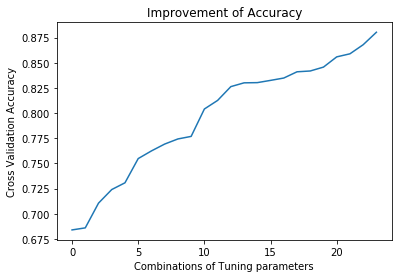

In [411]:
plot_sorted_accuracies(total_result, all_combined_exclude_subreddit_user, labels )
    


In [377]:
#Mean accuracies per setting
print('\n'.join(['%s: %.5f' % (s,v) for v,s in mean_accuracy_per_setting(total_result)]))

Model=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False): 0.85926
Model=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True): 0.84219
Model=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False): 0.83483
MinFreq=1: 0.81231
NGram=(1, 1): 0.80905
NFold=5: 0.79729
NGram=(1, 2): 0.79338
MinFreq=2: 0.79229
Use-IDF=True: 0.78048
SublinearTF=True: 0.77844
Model=SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1,

In [420]:
accuracy_data = {}

In [421]:
vocab, model,data_test, X_test, labels_test, predictions = fit_best_classifier_tfidf(all_combined_exclude_subreddit_user, total_result[0], labels)

0.8731608320649417


In [422]:
accuracy_data['Combined'] = accuracy(labels_test, predictions)

In [423]:
#top features for the combined data and top model 
topcoef((0,1), model, vocab, n = 10)

top weighted terms for reliable class:
  . Most correlated unigrams:
. news
. com
. gizmodo
. in
. uk
. india
. contactmusic
  . Most correlated bigrams:
. com news
. news comments
. contactmusic com
top weighted terms for fake class:
  . Most correlated unigrams:
. org
. conspiracy
. trump
. russia
. obama
. presstv
. us
. hillary
. shills
  . Most correlated bigrams:
. conspiracy comments


#### Plotting accuracies vs model

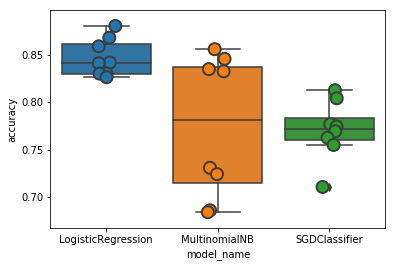

In [408]:

entries = []
for result in total_result:
    model_string = str(result['Model'])
    model_name = model_string.split("(")[0]
    entries.append((model_name, result['accuracy']))
cv_df = pd.DataFrame(entries, columns=['model_name', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=12, jitter=True, edgecolor="gray", linewidth=2)
plt.savefig('Plotting accuracies vs Model')
plt.show()

In [158]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LogisticRegression    0.846385
MultinomialNB         0.773643
SGDClassifier         0.769419
Name: accuracy, dtype: float64

#### Confusion Matrix

             precision    recall  f1-score   support

   Reliable       0.90      0.81      0.85       879
       Fake       0.86      0.93      0.89      1092

avg / total       0.87      0.87      0.87      1971



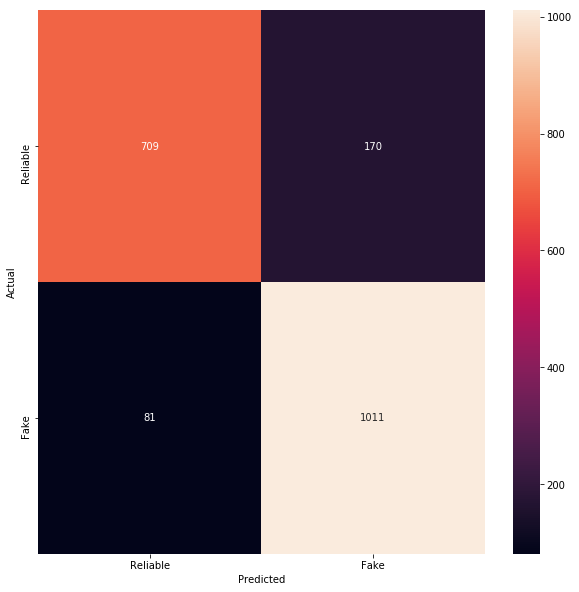

In [221]:
print_metrics(labels_test, predictions)

#### Top misclassified

In [237]:

    
def print_top_misclassified(test_docs, test_labels, X_test, clf, n):

    predictions = clf.predict(X_test)
    predicted_prob = clf.predict_proba(X_test)
    output = []
    for i, predicted_vals in enumerate(predicted_prob):
        if predictions[i] != test_labels[i]:
            if predictions[i] == 1:
                output.append((test_labels[i], predictions[i], predicted_vals[1], test_docs[i]))
            else:
                output.append((test_labels[i], predictions[i], predicted_vals[0], test_docs[i]))
    
    output = sorted(output, key=lambda tup: tup[2], reverse = True)
    for i in range(n):
        print("Predicted="+label_titles[output[i][1]]+" "+ "Truth=" + label_titles[output[i][0]]+ " "+"proba="+str(output[i][2]))
        print(output[i][3])

In [239]:
print_top_misclassified(data_test, labels_test, X_test, model, 10)

Predicted=Fake Truth=Reliable proba=0.9472766613160113
SeaWorld Employee Infiltrated PETAsource link: **[SeaWorld Employee Infiltrated PETA](http://www.rttnews.com/2522638/seaworld-supposedly-infiltrates-peta.aspx)**

poster: **[RoachesWinInTheEnd](/u/RoachesWinInTheEnd)**, [original conspiracy link](/r/conspiracy/comments/3daqn7/seaworld_employee_infiltrated_peta/)

-----------------------------------

Discourse level: 0%

Shills: 0%


Predicted=Fake Truth=Reliable proba=0.9183649902118596
Obama Tells Netanyahu To Stop Pushing Congress Toward New Iran Sanctionssource link: **[Obama Tells Netanyahu To Stop Pushing Congress Toward New Iran Sanctions](http://www.chinatopix.com/articles/33819/20150123/obama-tells-netanyahu-stop-pushing-congress-toward-new-iran-sanctions.htm)**

poster: **[NOT_JTRIG](/u/NOT_JTRIG)**, [original conspiracy link](/r/conspiracy/comments/2tfs1n/obama_tells_netanyahu_to_stop_pushing_congress/)

-----------------------------------

Discourse level: 100%

Shills: 

### Validation results on individual data groups using the top model

#### Validation results on comments

In [424]:
vocab, model,data_test, X_test, labels_test, predictions = fit_best_classifier_tfidf(trainingdata['comments'], total_result[0], labels)
topcoef((0,1), model, vocab, n = 20)
accuracy_data['Comments'] = accuracy(labels_test, predictions)

0.6514459665144596
top weighted terms for reliable class:
  . Most correlated unigrams:
. price
. games
. she
. in
. at
. stock
. hair
. market
. company
. my
. sell
. year
. love
. business
. duterte
. home
. beauty
. tech
. movie
. mom
  . Most correlated bigrams:
. 
top weighted terms for fake class:
  . Most correlated unigrams:
. trump
. conspiracy
. post
. russia
. truth
. clinton
. link
. america
. russian
. race
. by
. org
. information
. sources
. government
. us
. election
. evidence
. believe
. against
  . Most correlated bigrams:
. 


             precision    recall  f1-score   support

   Reliable       0.80      0.29      0.43       879
       Fake       0.62      0.94      0.75      1092

avg / total       0.70      0.65      0.61      1971



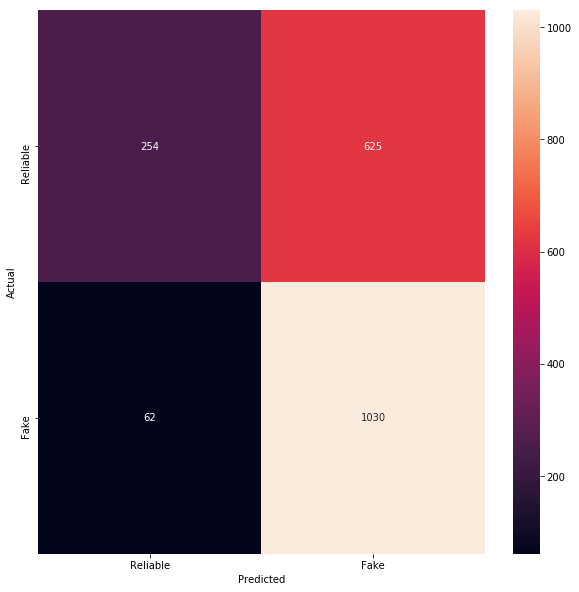

In [263]:
print_metrics(labels_test, predictions)

#### Validation of Text Posts

In [425]:
vocab, model,data_test, X_test, labels_test, predictions = fit_best_classifier_tfidf(trainingdata['post_selftext'], total_result[0], labels)
topcoef((0,1), model, vocab, n = 20)
accuracy_data['Post Text'] = accuracy(labels_test, predictions)

0.8097412480974124
top weighted terms for reliable class:
  . Most correlated unigrams:
. news
. jpg
. story
. sports
. articles
. images
. htm
. bitcoin
. season
. game
. review
. cms
. brecorder
. tech
. cdn
  . Most correlated bigrams:
. com news
. com articles
. news comments
. http images
. brecorder com
top weighted terms for fake class:
  . Most correlated unigrams:
. org
. conspiracy
. trump
. obama
. hillary
. clinton
. russia
. war
. shills
. us
. discourse
. level
. poster
. american
  . Most correlated bigrams:
. conspiracy comments
. discourse level
. link conspiracy
. conspiracy link
. original conspiracy
. source link


             precision    recall  f1-score   support

   Reliable       0.78      0.80      0.79       879
       Fake       0.84      0.82      0.83      1092

avg / total       0.81      0.81      0.81      1971



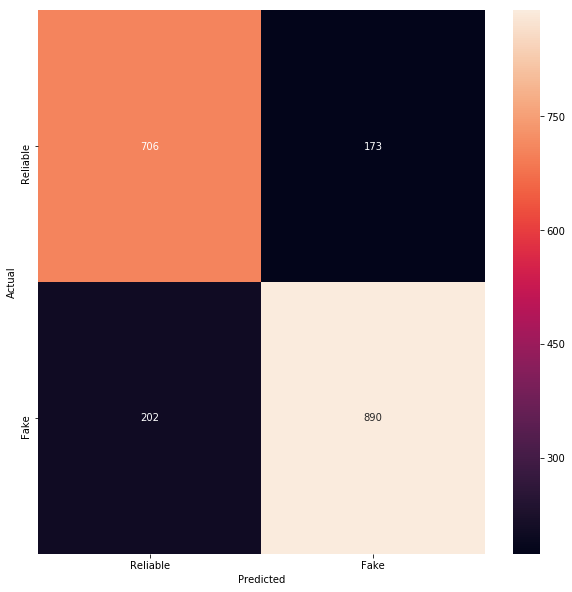

In [265]:
print_metrics(labels_test, predictions)

#### Validation of Subreddit name

In [16]:
#Removing the prefix characters in subreddit
subreddit = []
for text in trainingdata['post_subreddit_name_prefixed']:
    subreddit.append(text[2:])
subreddit[:10]

['removalbot',
 'politics',
 'AmericanPolitics',
 'phish',
 'removalbot',
 'frontconspiracy',
 'USNEWS',
 'hiphopheads',
 'removalbot',
 'AskReddit']

In [385]:
vocab, model,data_test, X_test, labels_test, predictions = fit_best_classifier_tfidf(subreddit, total_result[0], labels)
topcoef((0,1), model, vocab, n = 20)
accuracy_data.append(accuracy(labels_test, predictions))

0.7706747843734145
top weighted terms for reliable class:
  . Most correlated unigrams:
. teenmom
. southafricanews
. ireland
. philippines
. kwazulunatal
. india
. makeupaddiction
. googlenewsfeed
. investing
. saskatoon
. weedstocks
. teenmomogandteenmom2
. asianbeauty
. komets
. boston
. ipl
. dctv_universe
. longhornnation
. northernireland
. skincareaddiction
  . Most correlated bigrams:
. 
top weighted terms for fake class:
  . Most correlated unigrams:
. conspiro
. the_donald
. c_s_t
. dncleaks
. conspiracy
. podemos
. frontpolitics
. nascar
. contentthief
. squaredcircle
. debatealtright
. worldpolitics
. skeptic
. uncensorship
. frontconspiracy
. hfy
. formula1
. changemyview
. badhistory
. syriancivilwar
  . Most correlated bigrams:
. 


             precision    recall  f1-score   support

   Reliable       0.79      0.66      0.72       879
       Fake       0.76      0.86      0.81      1092

avg / total       0.77      0.77      0.77      1971



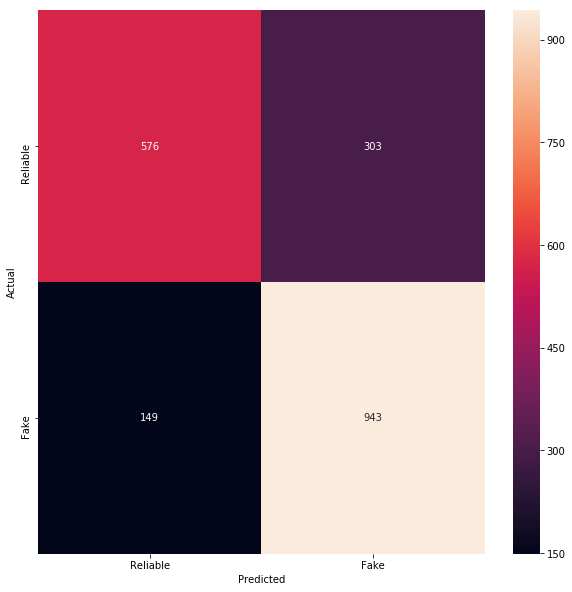

In [267]:
print_metrics(labels_test, predictions)

####  Merging post title and comments - Validation

In [426]:
#Merging title and comments
title_comments = []
for i in range(len(trainingdata)):
    title = trainingdata['post_title'][i] + ' '+ trainingdata['comments'][i]
    title_comments.append(title)

In [427]:
vocab, model,data_test, X_test, labels_test, predictions = fit_best_classifier_tfidf(title_comments, total_result[0], labels)
topcoef((0,1), model, vocab, n = 20)
accuracy_data['Title + comments'] = accuracy(labels_test, predictions)

0.8153221714865551
top weighted terms for reliable class:
  . Most correlated unigrams:
. com
. banned
. news
. gizmodo
. removed
. in
. uk
. 03
. within
. mediaite
. co
. india
. bitcoin
. ibtimes
  . Most correlated bigrams:
. removed from
. from news
. news within
. co uk
. mediaite com
. com by
top weighted terms for fake class:
  . Most correlated unigrams:
. russia
. obama
. org
. sputniknews
. conspiracy
. the
. presstv
. trump
. hillary
. insider
. truth
. dailywire
. us
. clinton
. truthdig
. america
  . Most correlated bigrams:
. sputniknews com
. presstv com
. dailywire com
. truthdig com


             precision    recall  f1-score   support

   Reliable       0.86      0.70      0.77       879
       Fake       0.79      0.91      0.85      1092

avg / total       0.82      0.82      0.81      1971



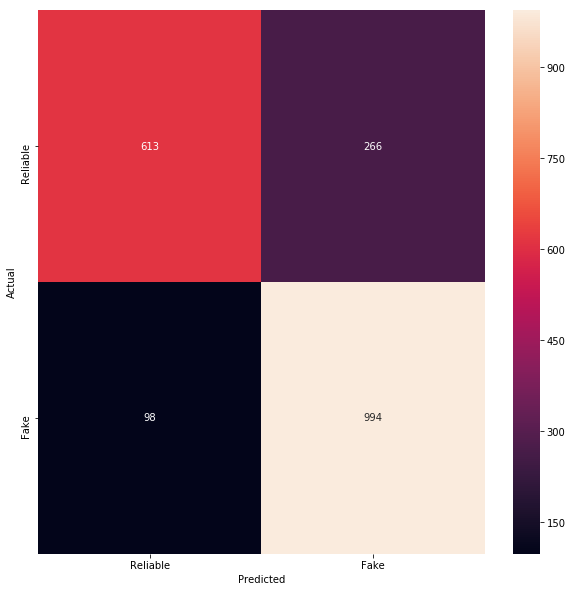

In [269]:
print_metrics(labels_test, predictions)

####  Merging post title and post text - Validation

In [428]:
#Merging title and comments
title_text = []
for i in range(len(trainingdata)):
    title = trainingdata['post_title'][i] +' ' + trainingdata['post_selftext'][i]
    title_text.append(title)

In [429]:
vocab, model,data_test, X_test, labels_test, predictions = fit_best_classifier_tfidf(title_text, total_result[0], labels)
topcoef((0,1), model, vocab, n = 20)
accuracy_data['Title + Post Text'] = accuracy(labels_test, predictions)

0.8883815322171487
top weighted terms for reliable class:
  . Most correlated unigrams:
. news
. com
. gizmodo
. ie
. uk
. co
. inquirer
. jpg
. wsj
. story
. bitcoin
. india
. contactmusic
  . Most correlated bigrams:
. com news
. co uk
. inquirer net
. wsj com
. news comments
. com articles
. independent ie
top weighted terms for fake class:
  . Most correlated unigrams:
. org
. conspiracy
. russia
. trump
. obama
. presstv
. us
. sputniknews
. truthdig
. war
. shills
. muslim
. hillary
. discourse
. level
  . Most correlated bigrams:
. conspiracy comments
. sputniknews com
. truthdig com
. discourse level
. link conspiracy


             precision    recall  f1-score   support

   Reliable       0.93      0.82      0.87       879
       Fake       0.86      0.95      0.90      1092

avg / total       0.89      0.89      0.89      1971



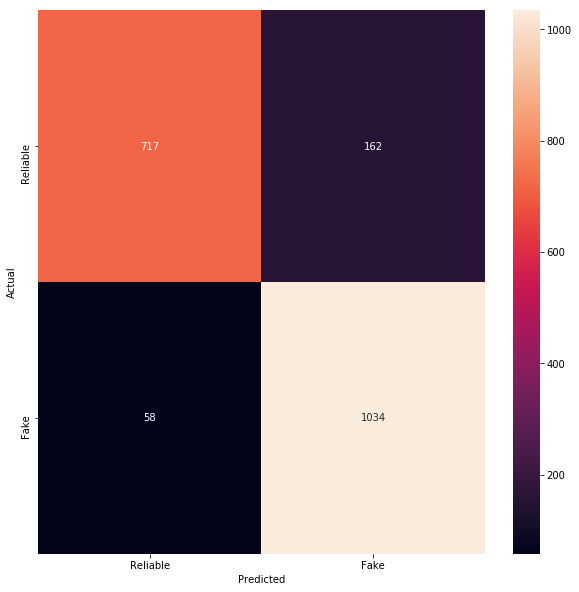

In [431]:
print_metrics(labels_test, predictions)

#### Validation of author name

In [395]:
vocab, model,data_test, X_test, labels_test, predictions = fit_best_classifier_tfidf(trainingdata['post_author'], total_result[0], labels)
topcoef((0,1), model, vocab, n = 20)
accuracy_data['Author Name'] = accuracy(labels_test, predictions)

0.6925418569254186
top weighted terms for reliable class:
  . Most correlated unigrams:
. kindofstephen
. stupidvoter
. thecometian
. lionsheart101
. sidnsfw
. shaleensinha88
. longhornmod
. eagle713
. louiseber
. denver_mods
. removalbot
. ksw8674
. apocza
. dextermilburn
. b1tcc
. freebutch
. panditji_reloaded
. rejectsandlosers
. dvstud
. mo9731
  . Most correlated bigrams:
. 
top weighted terms for fake class:
  . Most correlated unigrams:
. conspirobot
. j_dillinger
. acloudrift
. axolotl_peyotl
. nathanohio
. nascarthreadbot
. medically
. make_mind_free2go
. blogspammr
. frontbot
. politicsmoderatorbot
. admirablebyrd
. nucensorship
. marquisdepaid
. older_and_wiser_now
. 911bodysnatchers322
. offense_is_ok
. vigorous
. defnothilldawg
. tastypies
  . Most correlated bigrams:
. 


#### Accuracy improvement vs Features

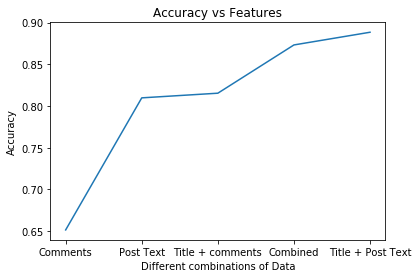

In [430]:
xtitles = []
yvalues = []
x = []
for key, value in sorted(accuracy_data.items(), key= lambda tup: tup[1]):
    xtitles.append(key)
    yvalues.append(value)
#print(xtitles)
for i in range(len(xtitles)):
    x.append(i)
plt.xlabel('Different combinations of Data')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Features')
plt.xticks(x, xtitles)
plt.plot(x, yvalues)
plt.savefig('Accuracy improvement with data.png')
plt.show()

#### Further improvements to the model

In [442]:
#Running SelectkBest with different k values on top of the model for checking improvement in accuracy
def fit_exp_classifier_tfidf_featselect(df_col, result, labels , k) :
    
    data_train, data_test, labels_train, labels_test = train_test_split(df_col, labels, test_size=0.20, random_state=42)
    vectorizer = TfidfVectorizer(min_df = result['MinFreq'], ngram_range = result['NGram'], use_idf = result['Use-IDF'] , 
                                sublinear_tf = result['SublinearTF'])
    #vocab = np.array(vectorizer.get_feature_names())
    model = result['Model']
    for i in k:
        #Feature selection using K-Best
        X = vectorizer.fit_transform(data_train)
        ch2 = SelectKBest(chi2, k=i)
        X  = ch2.fit_transform(X, labels_train)
        X_test = vectorizer.transform(data_test)
        X_test = ch2.transform(X_test)
    
        model.fit(X, labels_train)
    
        predictions = model.predict(X_test)
        print("Accuracy for model with k=%s is %f" %(str(i) , accuracy(labels_test, predictions))) 
   

In [444]:
fit_exp_classifier_tfidf_featselect(all_combined_exclude_subreddit_user, total_result[0], labels , [5,10,20])

Accuracy for model with k=5 is 0.620497
Accuracy for model with k=10 is 0.621005
Accuracy for model with k=20 is 0.621005


In [445]:
# Pipelining feature selection + Classification with l1 and l2 penalties

    
data_train, data_test, labels_train, labels_test = train_test_split(all_combined_exclude_subreddit_user, labels, test_size=0.20, random_state=42)
vectorizer = TfidfVectorizer(min_df = total_result[0]['MinFreq'], ngram_range = total_result[0]['NGram'], use_idf = total_result[0]['Use-IDF'] , 
                                sublinear_tf = total_result[0]['SublinearTF'])
    #vocab = np.array(vectorizer.get_feature_names())
model = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])
    
X = vectorizer.fit_transform(data_train)
X_test = vectorizer.transform(data_test)
model.fit(X, labels_train)
predictions = model.predict(X_test)
print("Accuracy for model  is %f" %( accuracy(labels_test, predictions))) 

Accuracy for model  is 0.901573


             precision    recall  f1-score   support

   Reliable       0.89      0.88      0.89       879
       Fake       0.91      0.92      0.91      1092

avg / total       0.90      0.90      0.90      1971



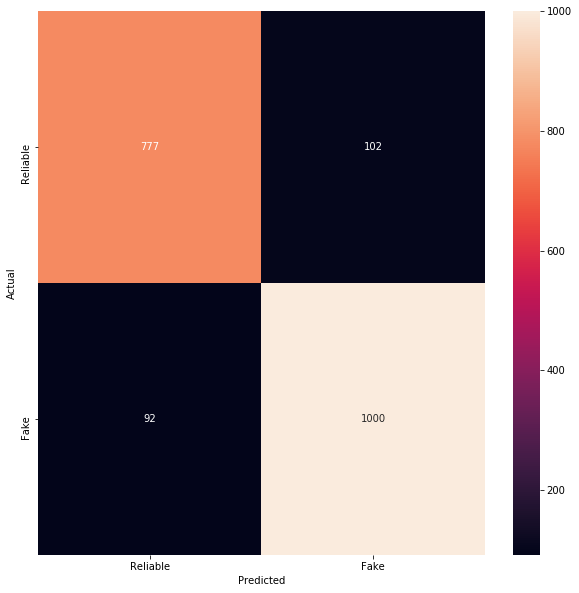

In [446]:
print_metrics(labels_test, predictions)
#Classification of Reliable documents have improved , but the recall of Fake news went up from the previous results.